In [1]:
import pandas as pd
import csv
import chardet
import datetime
import numpy as np
from collections import Counter
from numpy import where
import matplotlib.pyplot as plt
from sklearn.svm import SVC, OneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score
import sklearn.metrics
import sklearn.ensemble
from sklearn.tree import export_graphviz


I had trouble with reading one of the provided csv files. It seems that we need to specify the encoding. Using a function to detect the encoding, we proceed. 

In [2]:
def predict_encoding(file_path, n_lines=20):
    '''Predict a file's encoding using chardet'''

    # Open the file as binary data
    with open(file_path, 'rb') as f:
        # Join binary lines for specified number of lines
        rawdata = b''.join([f.readline() for _ in range(n_lines)])

    return chardet.detect(rawdata)['encoding']


In [3]:
predict_encoding('takehome_users.csv', n_lines = 200000)

'ISO-8859-1'

Add pass the encoding to the pd.read_csv API. 

In [4]:
df_users = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
df_users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


According to the documentation, df_users contains the following:

object_id: a unique user's id

creation_time: when they created their account

name: the user's name

email: the user's email address

creation_source: This contains information about how their account was created and contains one of five values:

    PERSONAL_PROJECTS: invited to join another user's personal workspace; 
    GUEST_INVITE: invited to an organization as a guest (limited permissions);
    ORG_INVITE: invited to an organization (as a full member);
    SIGNUP: signed up via the website;
    SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)

last_session_creation_time: UNIX timestamp of their last login

opted_in_to_mailing_list: whether they have opted into receiving marketing  emails

enabled_for_marketing_drip: whether they are on the regular marketing email drip

org_id: the organization (group of users) they belong to

invited_by_user_id: which user invited them to join (if applicable.)


In [5]:
df_users.rename(columns={'object_id':'user_id'}, inplace=True)
df_users.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [6]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [7]:
len(df_users)

12000

In [8]:
# change date columns to datetime
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], infer_datetime_format=True)
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'], infer_datetime_format=True)

In [9]:
s = df_users.loc[df_users['user_id'] == 137]
s.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
136,137,2012-11-15 23:07:41,Renwick Luca,LucaRenwick@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,9,NaN


Load the second csv. 

In [10]:
df_engagement = pd.read_csv('takehome_user_engagement.csv')
df_engagement.head(2)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


According to the documentation, df_engagement contains a row for each day that a user logged into the product. 

Problem Statement:

If we define an adopted user as a user who has logged into the product on three separate days in at least one 7 day period, identify which factors predict future user adoption. 

Please send us a brief writeup of your findings (the more concise, the better - no  more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable. 


We definitely have to use a predictive model which let's us see the feature weights. Perhaps we will use logistic regression. 

In [11]:
len(df_engagement), len(df_users)

(207917, 12000)

We need to classify each user as an adopted user or not. 

In [12]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [13]:
len(df_engagement['user_id'].unique())

8823

In [14]:
# convert time_stamp to datetime
df_engagement['time_stamp'] = pd.to_datetime(df_engagement['time_stamp'], infer_datetime_format=True)

In [15]:
# Grab the min and max log in dates so that we can possibly filter out records later
last_day = (datetime.datetime.utcnow() - (df_engagement['time_stamp'].max())).days
first_day = (datetime.datetime.utcnow() - (df_engagement['time_stamp'].min())).days

Users who are not otherwise adopters, who engaged twice between the first date, and 6 days later, and users who are not otherwise adopters and engaged twice between the last date and 6 days before, should be dropped from the df_users database as we cannot be sure that the did not engage a 3rd time either before our data started or after it completed. 

In [16]:
# get a complete list of user_ids from df_user
users = df_users.user_id.unique()
users = users.tolist()

In [17]:
# how many users
len(users)

12000

So every line in the df_users dataframe has a unique user. 

In [18]:
# identify whether a user has at least 3 separate log-ins within a 7 day period. 
freq = df_engagement.groupby(['user_id']).count() 
freq.head()

,time_stamp,visited
user_id,,
1,1,1
2,14,14
3,1,1
4,1,1
5,1,1


In [19]:
freq.describe(), len(freq)

(        time_stamp      visited
 count  8823.000000  8823.000000
 mean     23.565341    23.565341
 std      73.988152    73.988152
 min       1.000000     1.000000
 25%       1.000000     1.000000
 50%       1.000000     1.000000
 75%       3.000000     3.000000
 max     606.000000   606.000000,
 8823)

Most users only visited once. Anyone who visited less than 3 times is not an adopter. 
There are 8823 users in this record. Anyone who is listed on the df_users dataframe who is not included here is also not an adopter, as they never logged in at all. We can populate those records. 

In [20]:
# populate the adopter field with 0
df_users['adopter'] = 0

In [21]:
s = df_users[df_users['user_id'] == 137]
print(s)

     user_id       creation_time          name                    email  \
136      137 2012-11-15 23:07:41  Renwick Luca  LucaRenwick@hotmail.com   

       creation_source last_session_creation_time  opted_in_to_mailing_list  \
136  PERSONAL_PROJECTS                        NaT                         0   

     enabled_for_marketing_drip  org_id  invited_by_user_id  adopter  
136                           0       9                 NaN        0  


In [22]:
# Do we have any null values for adopter
df_users.adopter.isnull().sum()

0

In [23]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [24]:
df = df_engagement.groupby('user_id')['time_stamp'].apply(list)
type(df)

pandas.core.series.Series

In [25]:
df = pd.DataFrame(df)

In [26]:
# check to be sure I can access the list within the time_stamp
len(df.loc[2, 'time_stamp'])

14

In [27]:
def is_adopter(list):
    # function days a list of timestamps for a user
    # and returns 1 if the user is an adopter, else returns 0
    a = 0
    days = []
    
    # Change the list of times to a list of ints
    for item in list:
        delta = (datetime.datetime.utcnow() - item).days
        days.append(delta)
        
    for i in range(len(days)-1, 1, -1):
    
        if days[i-2] - days[i] <= 7:
            a = 1
            return a
        if abs(max(days) - first_day) <= 6:
            a = 3
            return a
        if abs(min(days) - last_day) <= 6:
            a = 3
            return a
    return a
    #print(days[i], days[i-2])

In [28]:
count = 0
for id, list in zip(df.index, df.time_stamp):
    a = is_adopter(list)
    df_users.loc[id, 'adopter'] = a
    count += 1
print(count)

8823


In [29]:
df_users.groupby(['adopter']).count() 

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
adopter,,,,,,,,,,
0.0,10294,10294,10294,10294,10294,7583,10294,10294,10294,5497
1.0,1558,1558,1558,1558,1558,1128,1558,1558,1558,845
3.0,148,148,148,148,148,112,148,148,148,75


In [30]:
# Do we have any null values for adopter
df_users.adopter.isnull().sum()

0

In [31]:
# Drop all records with "3" as adopter. We don't have enough information about these users to tell if they are adopters or not. 
df_users = df_users[df_users.adopter != 3]

In [32]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11853 entries, 0 to 12000
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     11852 non-null  float64       
 1   creation_time               11852 non-null  datetime64[ns]
 2   name                        11852 non-null  object        
 3   email                       11852 non-null  object        
 4   creation_source             11852 non-null  object        
 5   last_session_creation_time  8711 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    11852 non-null  float64       
 7   enabled_for_marketing_drip  11852 non-null  float64       
 8   org_id                      11852 non-null  float64       
 9   invited_by_user_id          6342 non-null   float64       
 10  adopter                     11853 non-null  float64       
dtypes: datetime64[ns](2), float64(6), object(3)
memory usa

In [33]:
df_users = df_users[df_users['user_id'].notnull()]

In [34]:
df_users.invited_by_user_id.fillna('none', inplace=True)

In [35]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11852 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     11852 non-null  float64       
 1   creation_time               11852 non-null  datetime64[ns]
 2   name                        11852 non-null  object        
 3   email                       11852 non-null  object        
 4   creation_source             11852 non-null  object        
 5   last_session_creation_time  8711 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    11852 non-null  float64       
 7   enabled_for_marketing_drip  11852 non-null  float64       
 8   org_id                      11852 non-null  float64       
 9   invited_by_user_id          11852 non-null  object        
 10  adopter                     11852 non-null  float64       
dtypes: datetime64[ns](2), float64(5), object(4)
memory usa

Our classification is 'adopter'. Let's check each column individually. Would be nice to make each a category and use a random forest model. 

'User_id' and 'name' are not important. We won't use that for machine learning. 'Last_session_creation_time' was already used as criteria for adopter or not an adopter. We also will not create any features around 'creation_time' due to time constraints of the problem. But it may be interesting to look at the time between creation_time and first login time. Such as, if a user is likely to adopt, perhaps he is likely to have adopted earlier. 

In [36]:
ml_df = df_users.drop(columns=['user_id', 'name', 'last_session_creation_time', 'creation_time',
                              'email'], axis=1)

In [37]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11852 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             11852 non-null  object 
 1   opted_in_to_mailing_list    11852 non-null  float64
 2   enabled_for_marketing_drip  11852 non-null  float64
 3   org_id                      11852 non-null  float64
 4   invited_by_user_id          11852 non-null  object 
 5   adopter                     11852 non-null  float64
dtypes: float64(4), object(2)
memory usage: 648.2+ KB


In [38]:
df2 = df_users.email.str.split('@').tolist()

In [39]:
# Categorical lists to be changed into dummies
cats = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id']
ml_df[cats] = ml_df[cats].astype('category')


In [40]:
ml_df[ml_df['adopter']==1]

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopter
2,ORG_INVITE,0.0,0.0,94.0,1525.0,1.0
10,SIGNUP,0.0,0.0,69.0,none,1.0
20,PERSONAL_PROJECTS,0.0,0.0,54.0,none,1.0
33,ORG_INVITE,0.0,0.0,33.0,3721.0,1.0
42,GUEST_INVITE,0.0,0.0,63.0,149.0,1.0
...,...,...,...,...,...,...
11965,PERSONAL_PROJECTS,0.0,0.0,39.0,none,1.0
11967,SIGNUP_GOOGLE_AUTH,1.0,1.0,273.0,none,1.0
11969,SIGNUP,0.0,0.0,126.0,none,1.0
11975,PERSONAL_PROJECTS,0.0,0.0,248.0,none,1.0


Future feature - use the domain name from the email addresses as a category. For now, we will not use it. 

Separate the data into features and target. 

In [41]:
X = ml_df.drop(columns=['org_id', 'invited_by_user_id', 'adopter'])
y = ml_df['adopter']

In [42]:
# change all categorical features into dummies and print out head
X = pd.get_dummies(data=X)

In [43]:
X.head()

,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_0.0,opted_in_to_mailing_list_1.0,enabled_for_marketing_drip_0.0,enabled_for_marketing_drip_1.0
0,1,0,0,0,0,0,1,1,0
1,0,1,0,0,0,1,0,1,0
2,0,1,0,0,0,1,0,1,0
3,1,0,0,0,0,1,0,1,0
4,1,0,0,0,0,1,0,1,0


In [45]:
# Train test split 
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15)

In [46]:
# determine class weights for unbalanced classes
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(class_weights)


[0.57578875 3.79864253]


In [48]:
# Instantiate model with class weights as dict
model = RandomForestClassifier(class_weight={1:class_weights[1], 0:class_weights[0]})

In [49]:
# fit model
model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5757887517146777,
                                     1: 3.7986425339366514})

In [50]:
# predict
ypred=model.predict(X_test)

In [51]:
# confirm that at least some instances of the minority class were predicted! 
np.unique(ypred)

array([0., 1.])

In [52]:
# get score
score = model.score(X_train, y_train)
print("Score: ", score)

Score:  0.6188207266229899


In [60]:
# get confusion matrix
cm = confusion_matrix(y_test, ypred)
print(cm)

[[1009  537]
 [ 131  101]]


In [61]:
# get classification report
cr = classification_report(y_test, ypred)
print(cr)

              precision    recall  f1-score   support

         0.0       0.89      0.65      0.75      1546
         1.0       0.16      0.44      0.23       232

    accuracy                           0.62      1778
   macro avg       0.52      0.54      0.49      1778
weighted avg       0.79      0.62      0.68      1778



In [62]:
# Extract single tree
estimator = model.estimators_[5]
print(estimator)

DecisionTreeClassifier(max_features='auto', random_state=641271167)


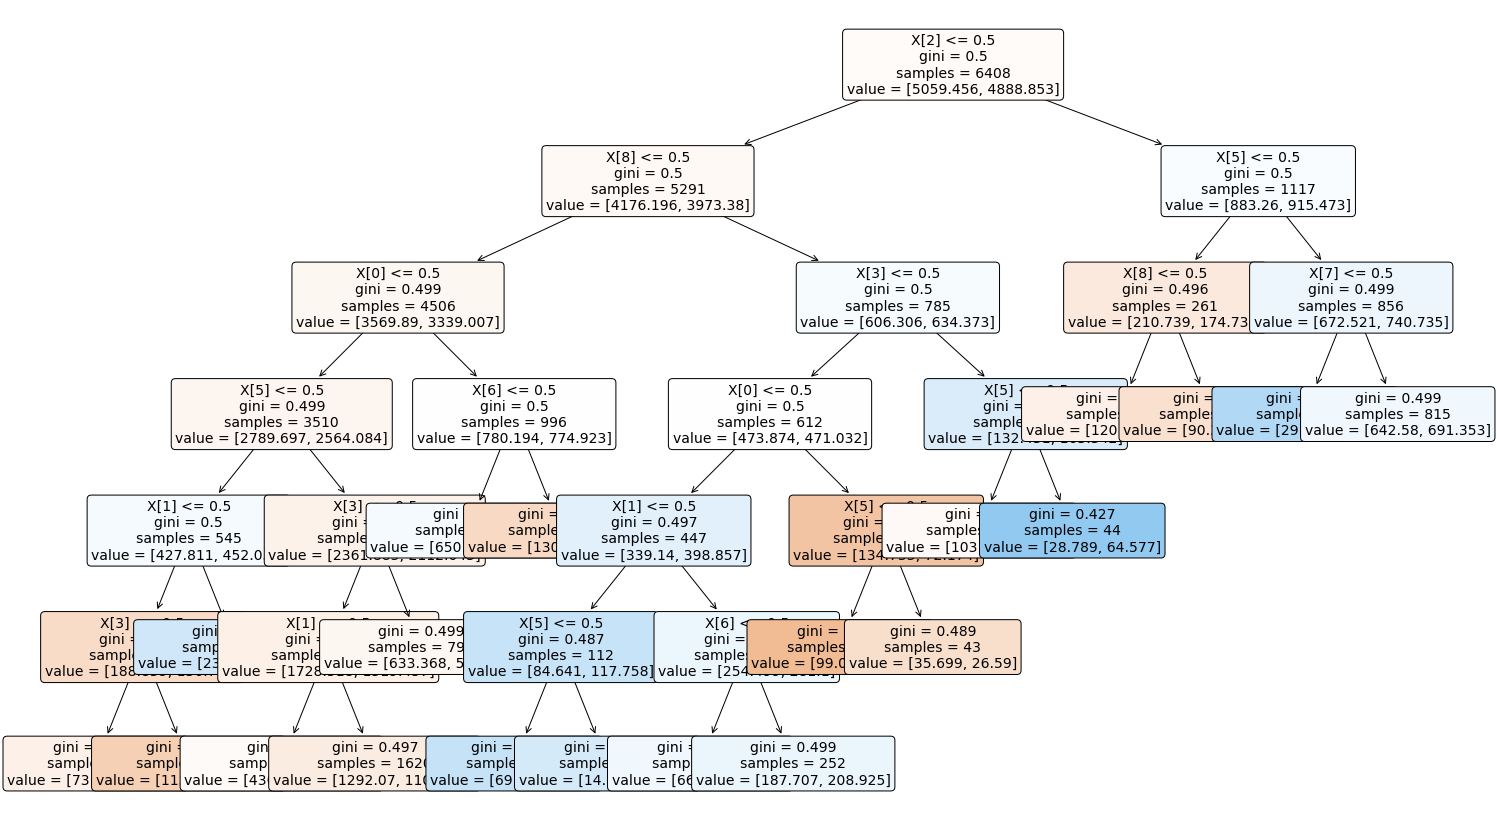

In [63]:
import pydot
# Pull out one tree from the forest
Tree = model.estimators_[5]
# Export the image to a dot file
from sklearn import tree
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14);

In [64]:
model.estimators_[0].tree_.max_depth

6

Another way to handle the imbalance might be to predict outliers. 

In [70]:
# mark inliers 1, outliers -1
y_test[y_test == 1] = -1
y_test[y_test == 0] = 1

In [71]:
# define outlier detection model
SVM = OneClassSVM(gamma='scale', nu=0.1)

In [75]:
# fit on majority class
#trainX = X_train[y_train==1]
#model.fit(trainX, y_test)

In [ ]:
# detect outliers in the test set
yhat = model.predict(X_test)

In [ ]:

# calculate score
score = f1_score(y_test, yhat, pos_label=-1)
print('F1 Score: %.3f' % score)

In [ ]:
# scatter plot of data by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

In [ ]:
cv_scores = cross_val_score(lsvc, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

In [76]:
# Try SVM
ypred = model.predict(X_test)

cm = confusion_matrix(y_test, ypred)
print(cm)


[[   0 1140  638]
 [   0    0    0]
 [   0    0    0]]


In [ ]:
# classification_report
cr = classification_report(y_test, ypred)
print(cr)